Importy Bibloitek

In [35]:
import json
import string

import os
import itertools as it
import operator as op
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud

import morfeusz2
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Odkomentować przy odtwarzaniu środowiska Python
# import nltk
# nltk.download("punkt_tab")

1. Utworzenie korpusu dokumentów

In [14]:
corpus_dir = "./literatura"
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
files = corpus.fileids()

2. Wstepne przygotowanie dokumentów (preprocessing)

In [30]:
documents = dict()

for file_name in files:
    documents[file_name] = corpus.raw(file_name)

with open("./stopwords_pl.txt", "r", encoding="UTF-8") as stoplist_file:
    stoplist = stoplist_file.read()

stoplist = stoplist.splitlines()
stoplist = stoplist[4:]

def lemmatize(text: str):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0, 1))

    def disambiguate(group):
        pairs = ((len(descr), lemma) for _, _, (_, lemma,descr, _, _) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    
    lemmas = (disambiguate(group) for _, group in segments)
    return " ".join(filter(str.isalpha, lemmas))

for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language="polish") if word not in stoplist])

3. Utworzenie macierzy częstości

In [31]:
docs = pd.DataFrame.from_dict(documents, orient='index')
docs.columns = ['content']

count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])

tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])

4. Chmury tagów

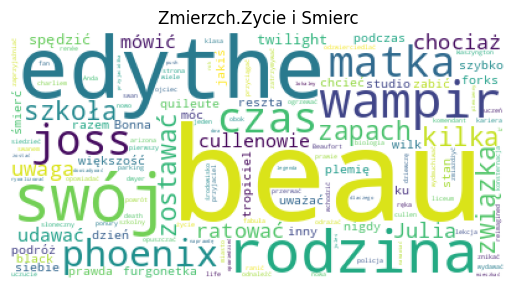

In [32]:
wordcloud = WordCloud(
    background_color='white',
    max_words=5_000,
    contour_width=3,
    contour_color='steelblue')

if not os.path.exists("./chmury"):
    os.mkdir("./chmury")

for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(index.replace(".txt", ""))
    plt.savefig("./chmury/{}".format(index.replace(".txt", ".png")))


5. Topic modelling

In [38]:
if not os.path.exists("./tematy"):
    os.mkdir("./tematy")

def plot_top_words(model, feature_names, n_top_words, title, subplots):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f"./tematy/{title}.png")

In [39]:
n_components = 6
feature_names = count_vectorizer.get_feature_names_out()
n_top_features = 20
subplots = (2,3)

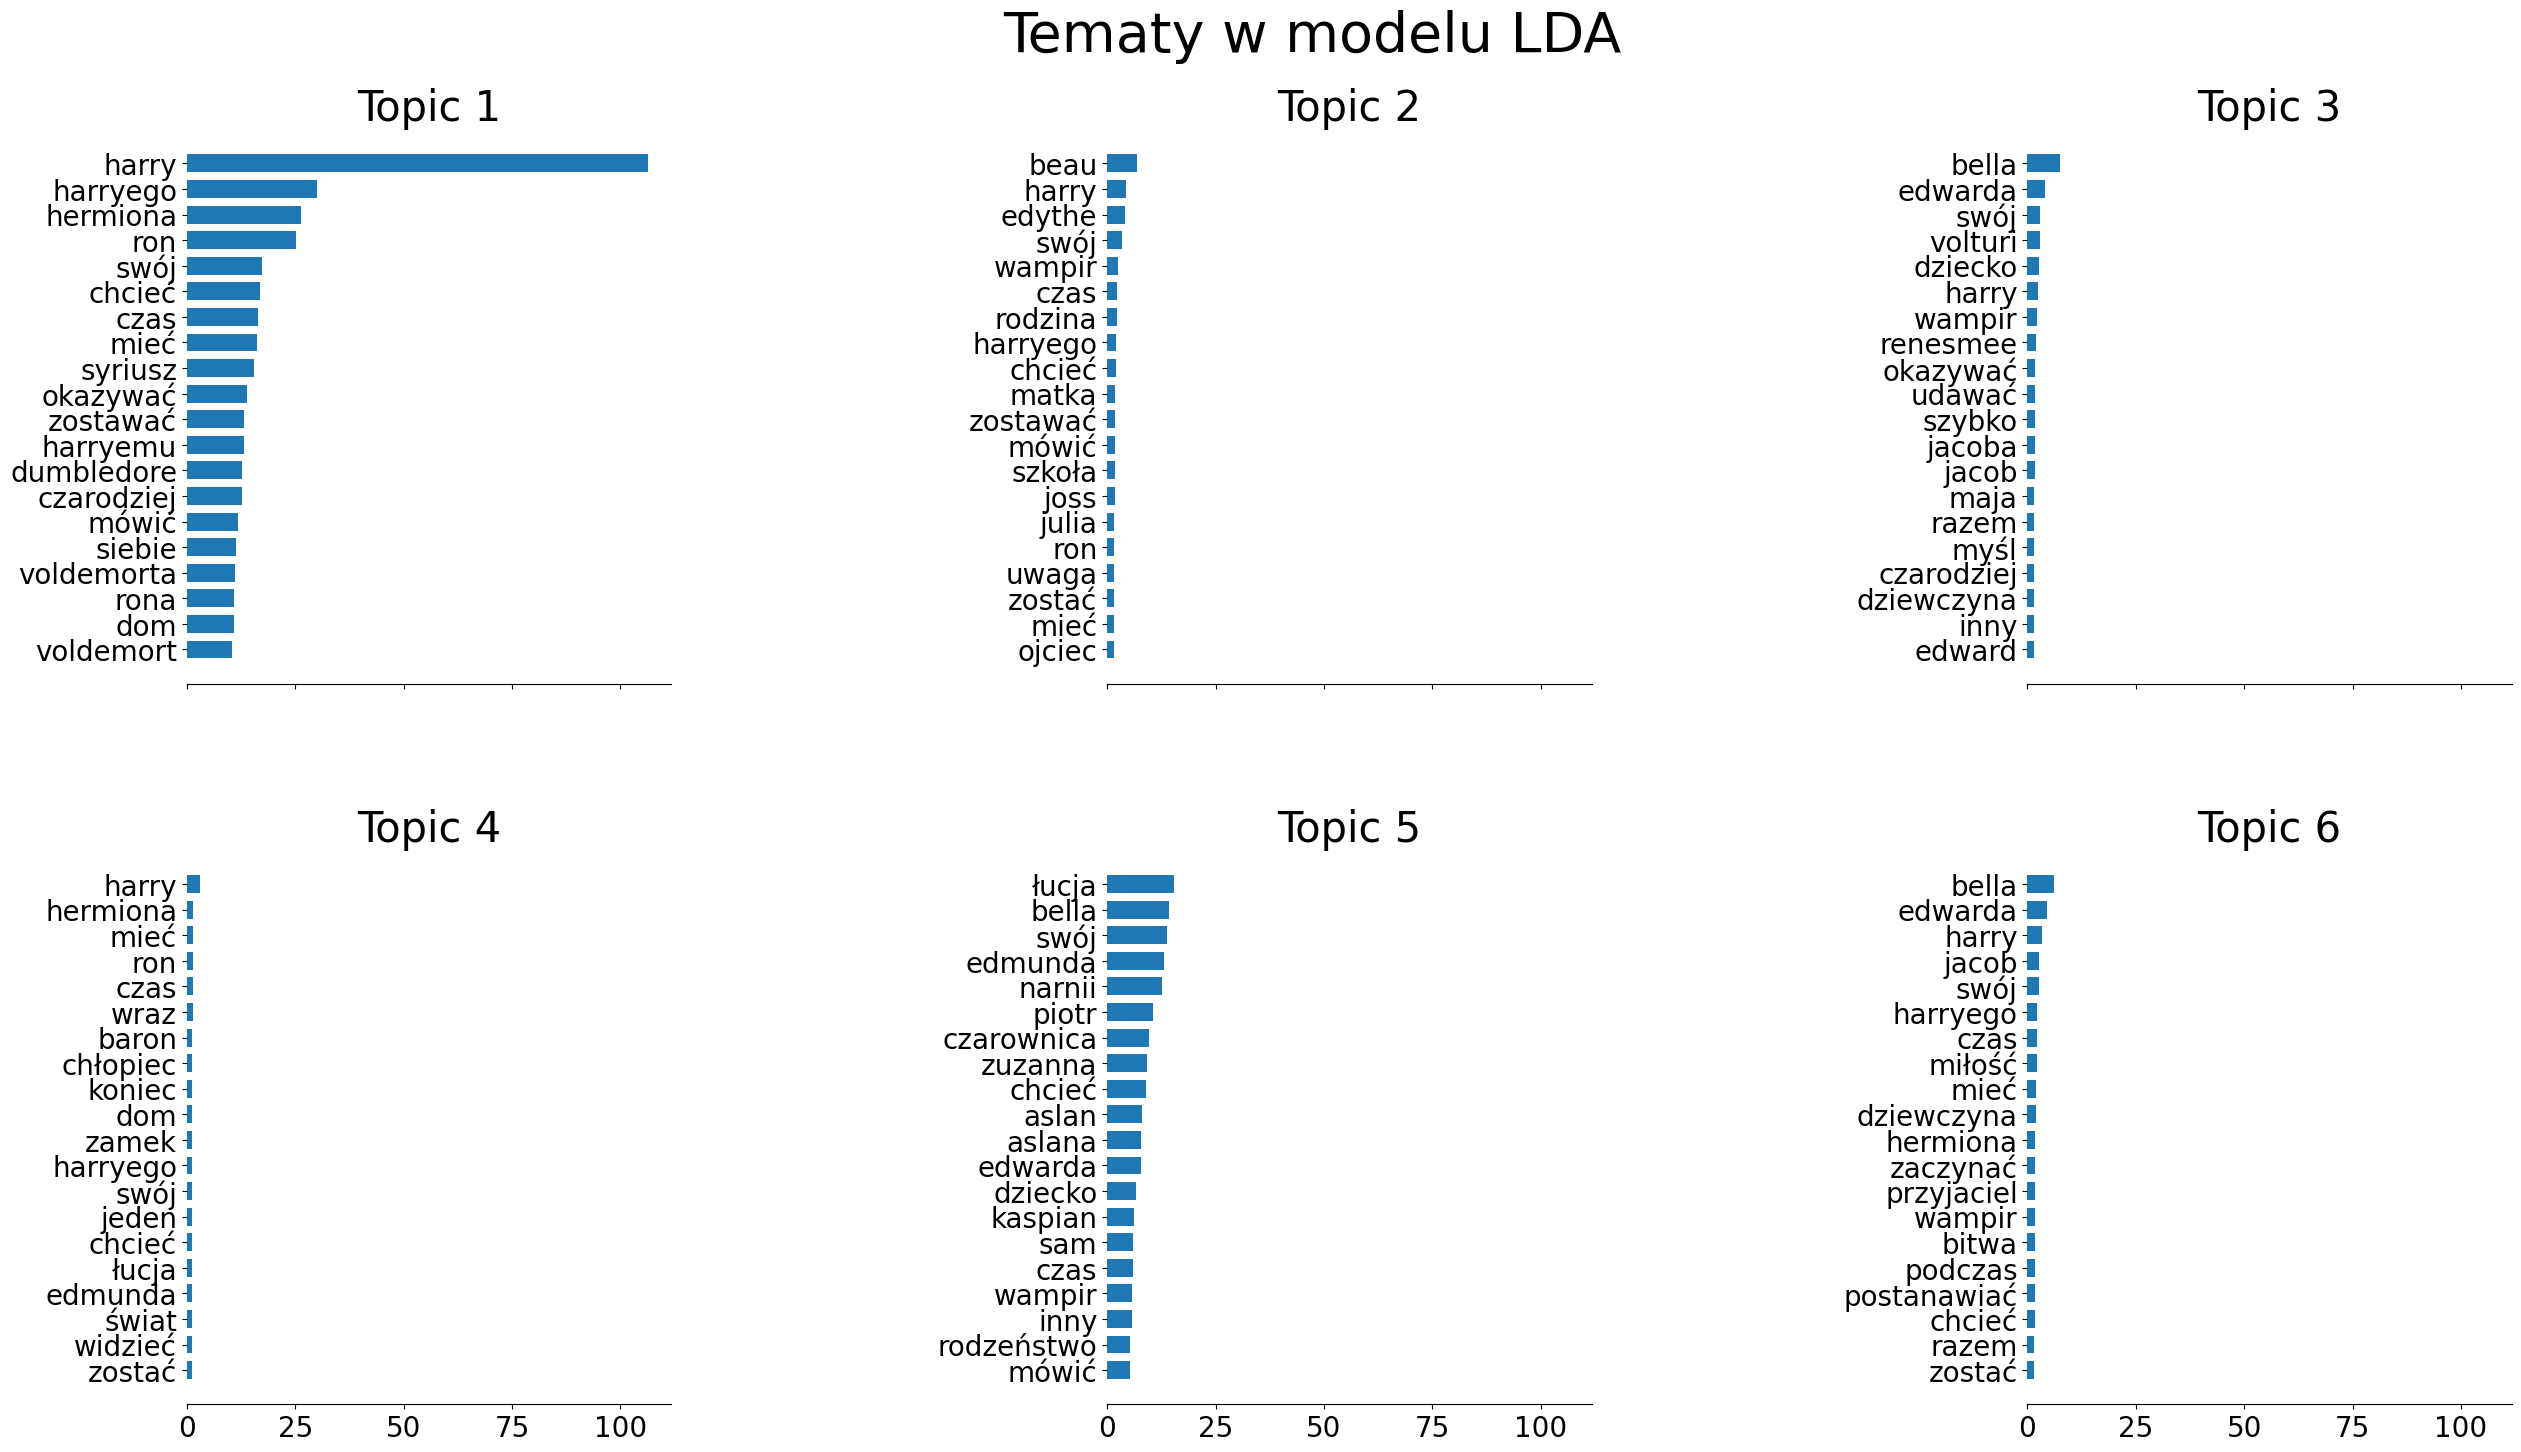

In [40]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method='online',
    learning_offset=50,
    random_state=0
)

lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_features, "Tematy w modelu LDA", subplots=subplots)

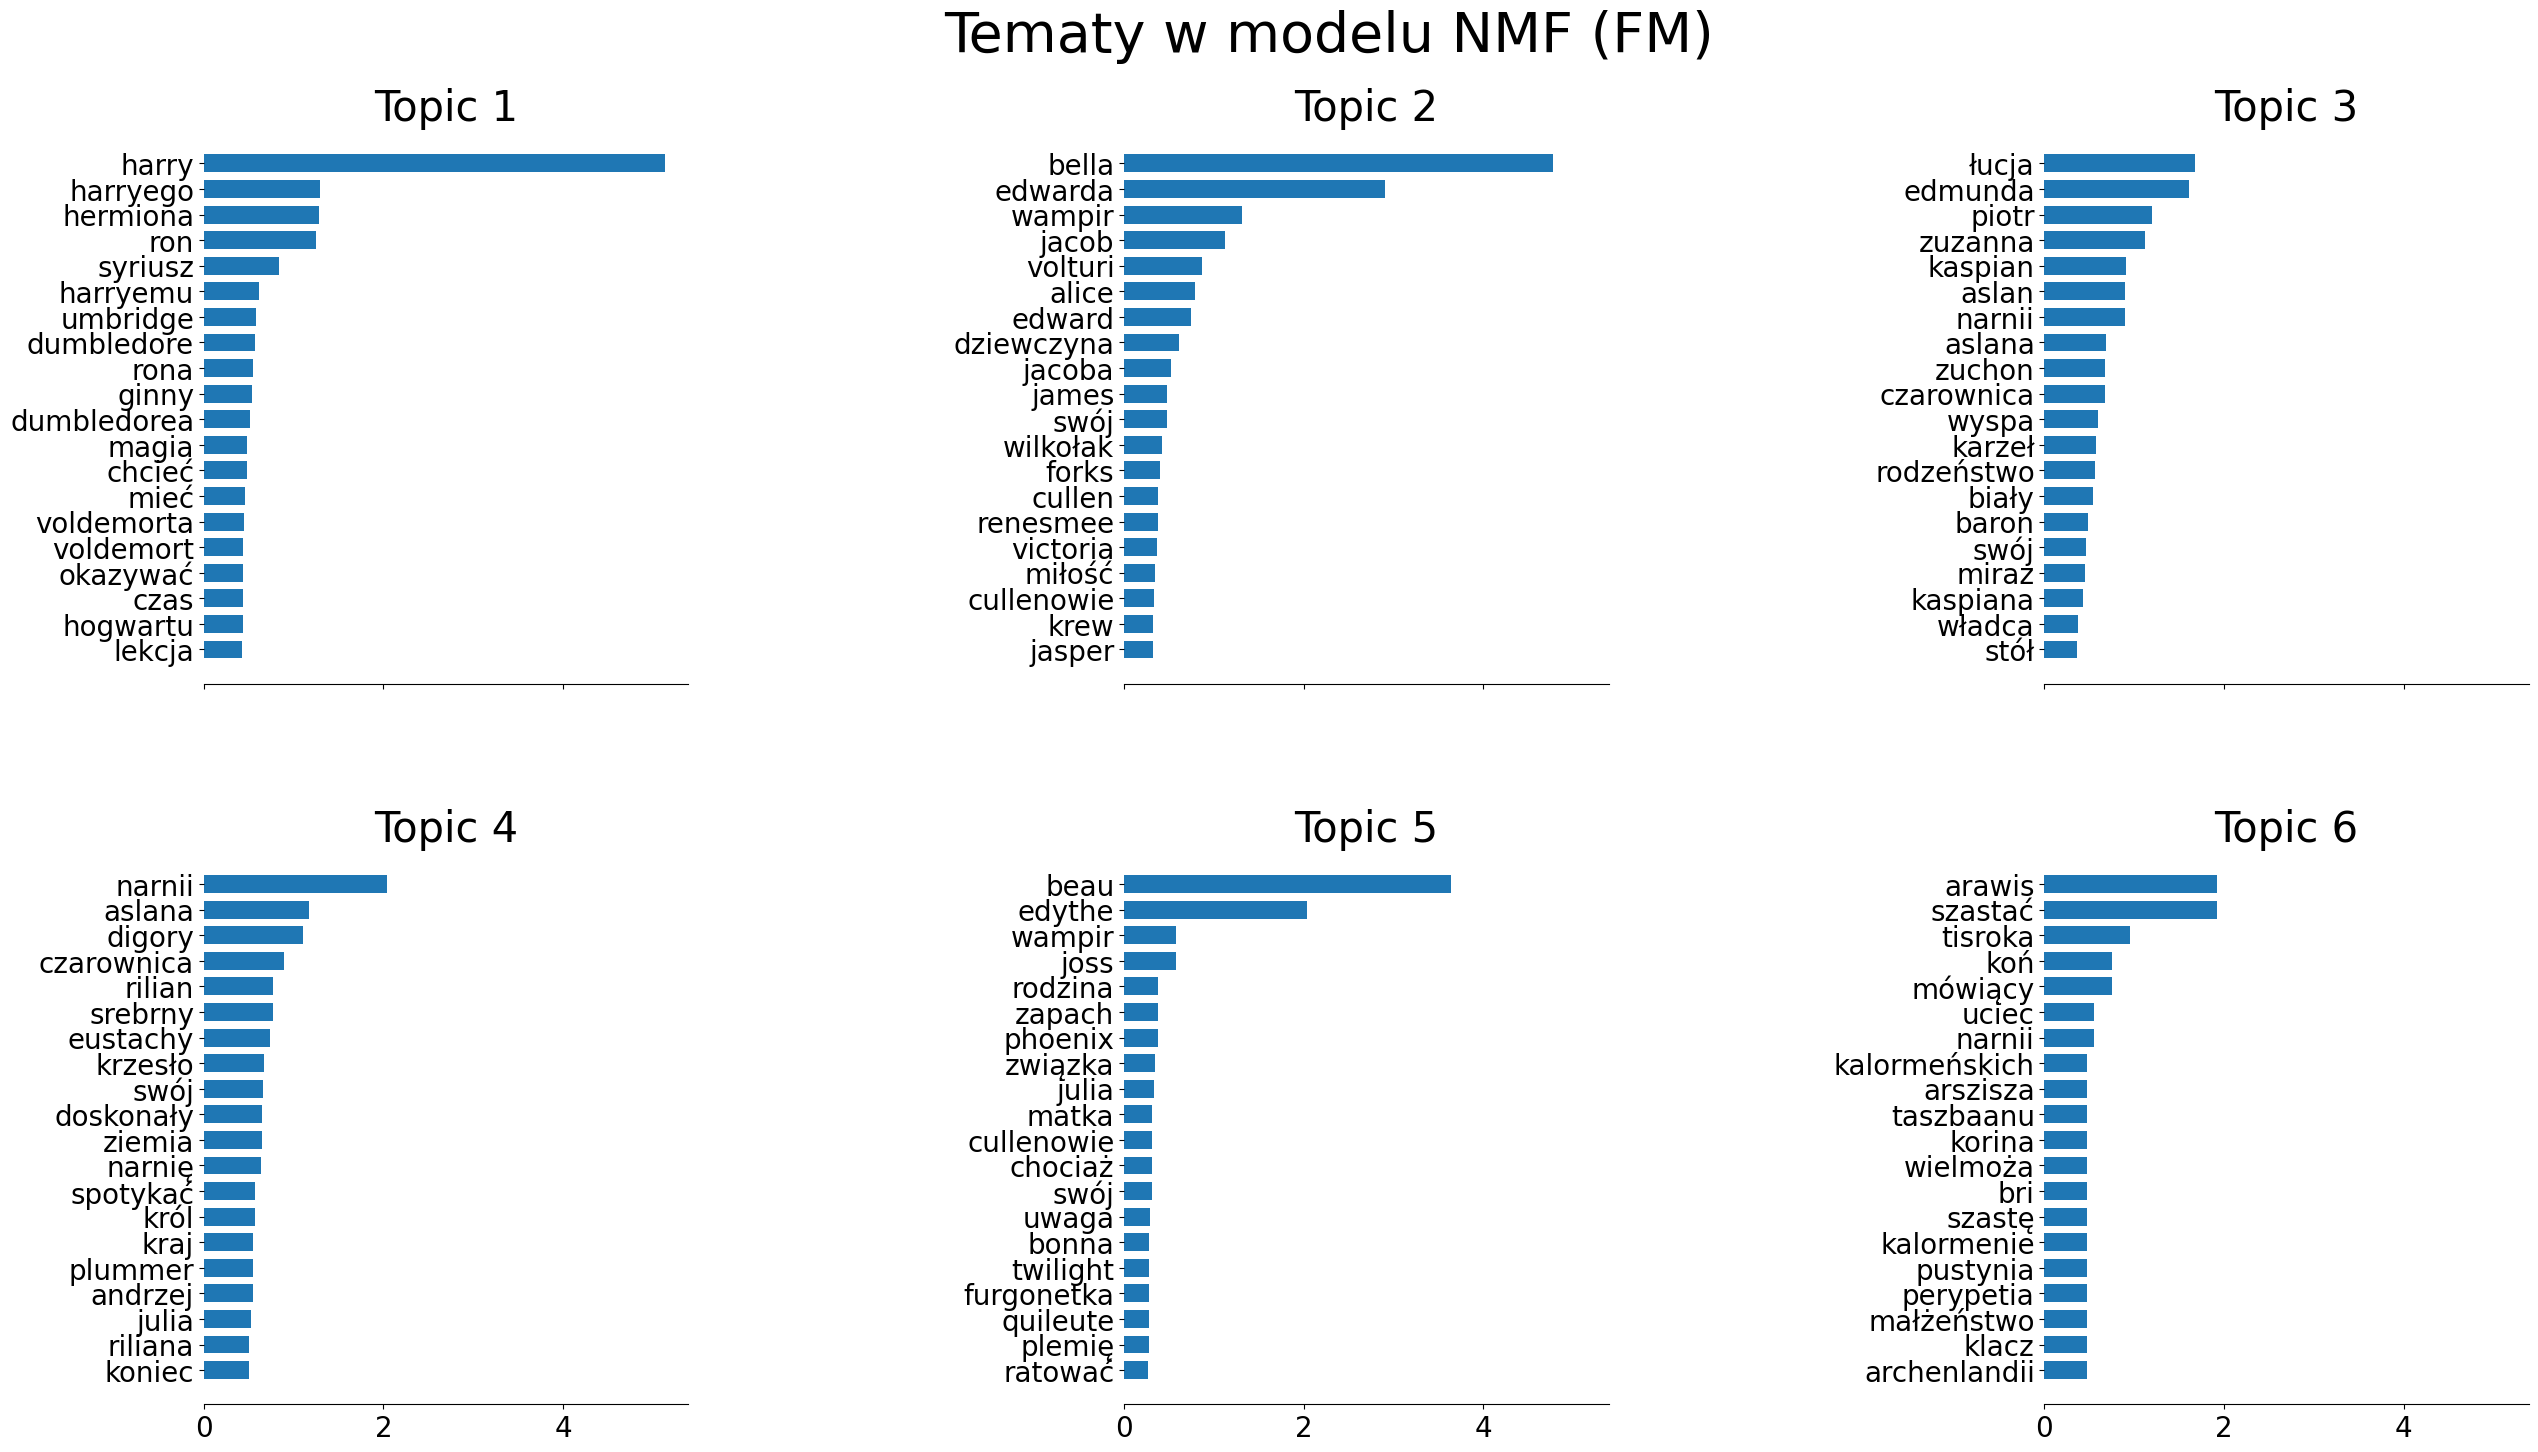

In [42]:
nmf_fm = NMF(
    n_components=n_components,
    random_state=1, 
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_fm.fit(counts_tfidf)
plot_top_words(nmf_fm, feature_names, n_top_features, "Tematy w modelu NMF (FM)", subplots=subplots)

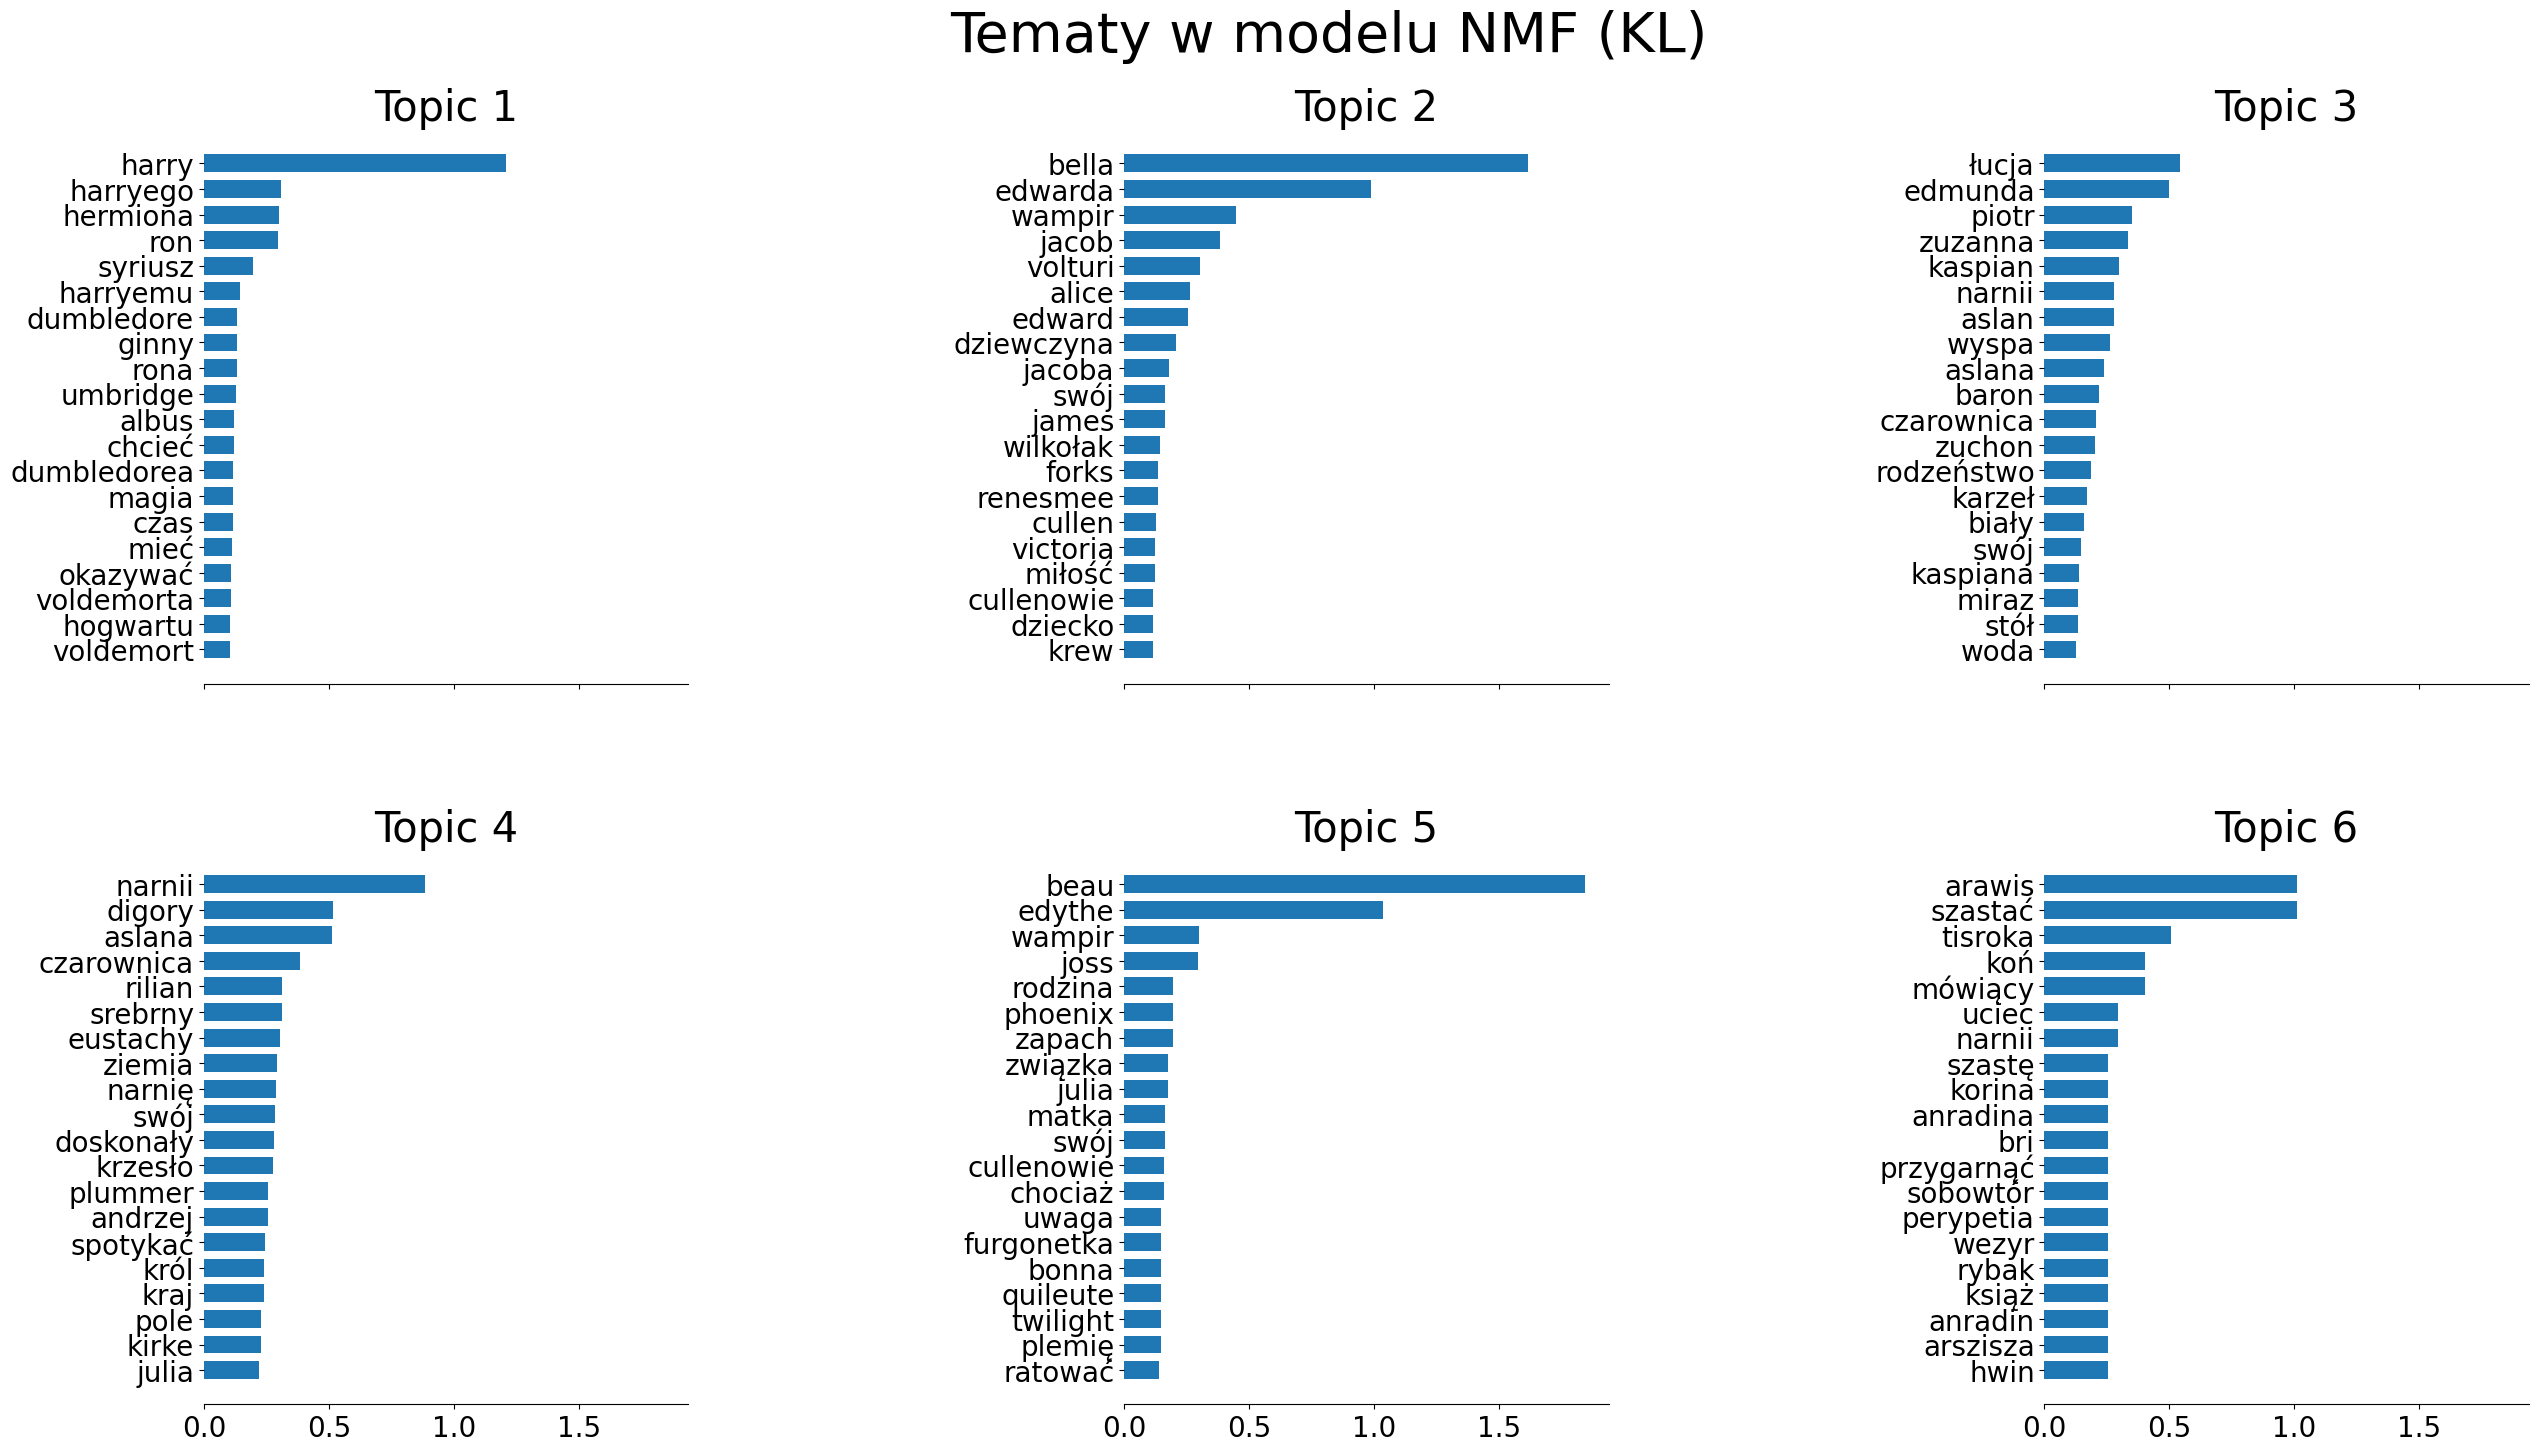

In [43]:
nmf_kl = NMF(
    n_components=n_components,
    random_state=1, 
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_kl.fit(counts_tfidf)
plot_top_words(nmf_kl, feature_names, n_top_features, "Tematy w modelu NMF (KL)", subplots=subplots)